# Purpose: CGAM Across Feature Subsets
- Splits gait features into four subsets: Spatial, Temporal, Kinematic, and EMG.
- **From AK's MAIN** Computes CGAM per gait cycle for each subject and intervention within each feature subset.
- **From AK's MAIN** Calculates subject-level Cohen's d (effect size) for CGAM, comparing pre- and post-intervention.
- **From AK's MAIN** Filters features for collinearity using Variance Inflation Factor (VIF).
- Performs repeated-measures ANOVAs across interventions and then across feature subsets.
- Summarizes CGAM and Cohen's d ranges for validation.
- Generates boxplots of Cohen's d by subset and intervention.
- Saves all results and figures.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import os

## Define Functions

In [56]:
def create_labels(stim_df, nostim_df, label_name):
    # Align by Subject
    stim_aligned = stim_df.set_index('Subject')
    nostim_aligned = nostim_df.set_index('Subject')

    # Keep only common subjects
    common_subjects = stim_aligned.index.intersection(nostim_aligned.index)
    stim_common = stim_aligned.loc[common_subjects]
    nostim_common = nostim_aligned.loc[common_subjects]

    # Compare CGAM
    condition = (stim_common['CGAM'] > nostim_common['CGAM'])

    # Build labels dataframe
    labels_df = pd.DataFrame({
        'Subject': common_subjects,
        'Stim Label': (condition).astype(int)  # 1 if stim did exceed no stim
    })

    # Save to dictionary
    stim_Label_new[label_name] = labels_df

    # Print counts
    print_label_counts(labels_df, label_name)
    
    return stim_Label_new

def paired_T_test(delta_stim_df, delta_nostim_df):
    """
    Performs paired t-tests comparing delta_stim vs delta_nostim for each feature.
    
    Assumes both dataframes have 'Subject', 'Trial', and feature_delta columns.
    
    Returns:
    pd.DataFrame with rows as features and columns: p-value, mean_stim, mean_nostim
    """
    # Merge to align by Subject and Trial
    merged = pd.merge(delta_stim_df, delta_nostim_df, on=['Subject', 'Trial'], suffixes=('_stim', '_nostim'))

    # Identify delta features (strip the "_delta" suffix)
    feature_names = [col.replace('_delta_stim', '') for col in merged.columns if col.endswith('_delta_stim')]

    results = []

    for feature in feature_names:
        stim_col = f"{feature}_delta_stim"
        nostim_col = f"{feature}_delta_nostim"

        stim_values = merged[stim_col]
        nostim_values = merged[nostim_col]

        # Paired t-test
        t_stat, p_val = ttest_rel(stim_values, nostim_values)

        results.append({
            'Feature': feature,
            'p-value': p_val,
            'mean_stim': stim_values.mean(),
            'mean_nostim': nostim_values.mean()
        })

    return pd.DataFrame(results)

def cohens_d(pre_df, post_df, features, trial=False):
    """
    Computes Cohen's d (paired or unpaired) for each feature per Subject + Intervention + Is_Stim.

    Parameters:
    pre_df (pd.DataFrame): PRE dataframe with Subject, Intervention, Is_Stim, Trial, and features.
    post_df (pd.DataFrame): POST dataframe with the same columns.
    features (list): List of feature column names.
    trial (bool): If True, matches trials for paired analysis; if False, performs unpaired analysis.

    Returns:
    pd.DataFrame: Rows are Subject, Intervention, Is_Stim, etc., with one column per feature's Cohen's d.
    """
    group_keys = ['Subject', 'Intervention', 'SessionOrder', 'Is_Stim', 'Frequency', 'Intensity']
    results = []

    # Group both dataframes
    pre_groups = pre_df.groupby(group_keys)
    post_groups = post_df.groupby(group_keys)

    for key in pre_groups.groups.keys():
        if key not in post_groups.groups:
            continue

        pre_group = pre_groups.get_group(key)
        post_group = post_groups.get_group(key)

        row = dict(zip(group_keys, key))

        if trial:
            # Merge on 'Trial' to ensure paired comparison only for matching trials
            merged = pd.merge(pre_group, post_group, on='Trial', suffixes=('_pre', '_post'))

            for feature in features:
                pre_vals = merged[f"{feature}_pre"]
                post_vals = merged[f"{feature}_post"]
                row[feature] = pg.compute_effsize(pre_vals, post_vals, paired=False, eftype='cohen')

        else:
            # Unpaired comparison (no merge)
            for feature in features:
                pre_vals = pre_group[feature].dropna()
                post_vals = post_group[feature].dropna()
                row[feature] = pg.compute_effsize(pre_vals, post_vals, paired=False, eftype='cohen')

        results.append(row)

    return pd.DataFrame(results)

def compute_vif(df, feature_cols, vif_threshold=5):
    """
    Compute VIF and remove features with high collinearity.

    Parameters:
    df (pd.DataFrame): DataFrame containing feature columns.
    feature_cols (list): List of feature column names.
    vif_threshold (float): Threshold for removing features with high VIF.

    Returns:
    list: List of selected features after VIF filtering.
    """
    selected_features = feature_cols.copy()
    
    while len(selected_features) > 1:
        X = df[selected_features].to_numpy()
        vif_values = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        
        # Create a DataFrame for VIF values
        vif_df = pd.DataFrame({"Feature": selected_features, "VIF": vif_values})
        max_vif = vif_df["VIF"].max()
        
        # Stop if all VIF values are below the threshold
        if max_vif < vif_threshold:
            break
        
        # Drop the feature with the highest VIF
        drop_feature = vif_df.loc[vif_df["VIF"].idxmax(), "Feature"]
        selected_features.remove(drop_feature)
        print(f"Dropping '{drop_feature}' with VIF={max_vif:.2f}")
    
    return selected_features

def calculate_cgam_grouped(df, groupby_cols, feature_cols):
    results = []
    grouped = df.groupby(groupby_cols)

    for group_name, group_df in grouped:
        if len(group_df) < 3:
            print(f"Skipped group: {group_name} (only {len(group_df)} strides)")
            continue

        # Symmetry matrix S: (strides x features)
        S = group_df[feature_cols].to_numpy()

        # Covariance matrix across all strides (features x features)
        K_S = np.cov(S, rowvar=False, bias=False)
        
        cond_number = np.linalg.cond(K_S)
        if cond_number > 1e10:
            print("Warning: Matrix is ill-conditioned")

        # Inverse covariance matrix
        K_S_inv = np.linalg.inv(K_S)

        denominator = np.sum(K_S_inv)

        # Compute CGAM for each stride
        for i, stride_S in enumerate(S):
            numerator = stride_S @ K_S_inv @ stride_S.T
            val = numerator / denominator
            if val < 0 or np.isnan(val):
                print(f"Warning: Invalid value inside sqrt in group {group_name}. Skipping stride {i}.")
                continue
            cgam_value = np.sqrt(val)

            # Collect metadata columns for this stride
            cycle_val = group_df['Cycle'].iloc[i]
            trial_val = group_df['Trial'].iloc[i]
            prepost_val = group_df['PrePost'].iloc[i]


            # Append all data
            results.append((*group_name, trial_val, prepost_val, cycle_val, cgam_value))

    # Create DataFrame with results
    result_df = pd.DataFrame(results, columns=groupby_cols + ['Trial', 'PrePost', 'Cycle', 'CGAM'])
    return result_df

def print_label_counts(label_df, label_name):
    print(f"\n{label_name}:")
    print("Stim:", (label_df['Stim Label'] == 0).sum())
    print("NoStim:", (label_df['Stim Label'] == 1).sum())

def print_binary_label_counts(condition_series, true_label, false_label, description):
    # Single, consolidated definition (duplicate removed)
    print(f"\n{description}:")
    print(f"{true_label}:", condition_series.sum())
    print(f"{false_label}:", (~condition_series).sum())

## Prep Data

In [57]:
# Load matched gait cycles data
Data_Path = r"Y:\LabMembers\MTillman\SavedOutcomes\StrokeSpinalStim\Overground_EMG_Kinematics\MergedTablesAffectedUnaffected10MWT\matchedCycles.csv"
allCycles_df = pd.read_csv(Data_Path)

# Drop SHAM1 intervention 
filteredCycles_df = allCycles_df[allCycles_df['Intervention'] != 'SHAM1']

#Relabeling Tol to become RMT because their 'Tol" intensity was at or below their 'RMT' intensity
relabel_dict = {'SS06':'TOL50', 'SS10':'TOL50','SS01':'TOL30'}
for subject, intervention in relabel_dict.items():
     mask = (filteredCycles_df['Subject'] == subject) & (filteredCycles_df['Intervention'] == intervention)
     filteredCycles_df.loc[mask, 'Intensity'] = 'RMT'

# # Features to Drop -- Does not go into VIF calculation due to missing data
dropCols = ['StanceDurations_GR_Sym', 'StrideWidths_GR_Sym', 'Single_Support_Time_GR_Sym','Double_Support_Time_GR_Sym', 'TenMWT']
filteredCycles_df = filteredCycles_df.drop(dropCols, axis=1)
# Insert 0 into Frequency for SHAM2 to avoid dropping SHAM2 because of "missing data"
filteredCycles_df.loc[filteredCycles_df['Intervention'] == 'SHAM2', 'Frequency'] = 0
filteredCycles_df = filteredCycles_df.dropna() 

#Select only symmetry-related features to go into VIF and CGAM Calculation
feature_cols = []
for col in filteredCycles_df.columns:
    if (
        isinstance(col, str) and
        'Sym' in col and
        col != 'NumSynergies_Sym' and
        'RMSE_EMG' not in col and
        'Lag_EMG' not in col and
        'Mag_EMG' not in col and
        'AUC_EMG' not in col and
        'RMS_EMG' not in col and
        'AUC_JointAngles' not in col and
        'JointAngles_Max' not in col and
        'JointAngles_Min' not in col
    ):
        feature_cols.append(col)
        
# columns to use to stratify the matrix calculation of CGAM - CGAM Matrix is calculated on each subject and intervention, all gait cycles (PRE and POST)
groupby_cols = ['Subject', 'Intervention', 'SessionOrder', 'Is_Stim','Frequency', 'Intensity', 'Speed'] 

# Available speeds to run analyses for (FV and SSV)
speeds = ['FV','SSV']

# Robustness check - confirm that there are no significant missing values in the dataset
missing_counts = filteredCycles_df.isnull().sum()
filtered_missing = missing_counts[missing_counts > 0]

if not filtered_missing.empty:
    print("Missing data detected:")
    print(filtered_missing)
else:
    print("No missing data found.")

No missing data found.


## Filter features (JH)

In [58]:
# Provide a helper to produce subsets for a given list of features (so subsets can be built per-speed)
def get_feature_subsets(cols):
    return {
        'Spatial': [p for p in cols if any(key in p for key in ['StepLengths', 'StepWidths', 'StrideLengths'])],
        'Temporal': [p for p in cols if any(key in p for key in ['StancePhasePerc', 'StepDurations', 'StrideDurations', 'StrideVelocities', 'SwingDurations', 'SwingPhasePerc'])],
        'Kinematic': [p for p in cols if 'JointAngles' in p],
        'EMG': [p for p in cols if 'EMG' in p]
    }


## Compute CGAM/Cohen's

In [59]:
# Run analysis per-speed and save outputs under results/<speed>/
RESULTS_BASE = r"Y:\LabMembers\J_Hunt\SS_Stroke\CGAM_Exploration\results"

for speed in speeds:
    print(f"\nProcessing speed: {speed}")
    speed_dir = os.path.join(RESULTS_BASE, speed)
    os.makedirs(speed_dir, exist_ok=True)
    FIGS_DIR = os.path.join(speed_dir, 'figures')
    STATS_DIR = os.path.join(speed_dir, 'stats')
    os.makedirs(FIGS_DIR, exist_ok=True)
    os.makedirs(STATS_DIR, exist_ok=True)

    speed_df = filteredCycles_df[filteredCycles_df['Speed'] == speed].copy()
    if speed_df.empty:
        print(f"No data for speed {speed}, skipping.")
        continue

    # Recompute available feature columns for this speed (in case some are missing)
    speed_feature_cols = [c for c in feature_cols if c in speed_df.columns]

    feature_subsets_speed = get_feature_subsets(speed_feature_cols)

    # Initialize storage for results as lists for concatenation
    cgam_matrix_list = []
    cohens_df_list = []

    # Compute CGAM and cohen's d for each subset (for this speed)
    for subset_name, subset_features in feature_subsets_speed.items():
        if not subset_features:
            print(f"Skipping empty subset {subset_name} for speed {speed}")
            continue

        # Demean the data prior to VIF calculation
        filteredCycles_demean = speed_df.copy()
        filteredCycles_demean[subset_features] = speed_df[subset_features].apply(lambda x: x - x.mean())

        # Compute VIF and return non-collinear features to be used in CGAM
        print(f'Starting VIF Computation for {subset_name} Features (speed={speed})')
        VIF_features = compute_vif(filteredCycles_demean, subset_features)
        if not VIF_features:
            print(f"No features left after VIF for {subset_name} at speed {speed}. Skipping.")
            continue

        # CGAM Calculation on the group_by (per subject, per Intervention) on the VIF Features
        cgam_matrix = calculate_cgam_grouped(speed_df, groupby_cols, VIF_features)
        if cgam_matrix.empty:
            print(f"No CGAM results for subset {subset_name} at speed {speed}")
            continue
        cgam_matrix['Subset'] = subset_name  # Add subset label for later filtering
        cgam_matrix_list.append(cgam_matrix)

        # Filter by PRE/POST
        preData = cgam_matrix[cgam_matrix["PrePost"] == 'PRE'].copy()
        postData = cgam_matrix[cgam_matrix["PrePost"] == 'POST'].copy()
        preData['Subset'] = subset_name
        postData['Subset'] = subset_name
        preData['PrePostType'] = 'PRE'
        postData['PrePostType'] = 'POST'

        # Compute Cohen's d Post vs Pre of all gait cycles across all trials for each intervention
        features = ['CGAM']
        cohens_df = cohens_d(preData, postData, features)
        cohens_df['Subset'] = subset_name
        cohens_df_list.append(cohens_df)

    # Concatenate all lists/results into a single df and save per-speed
    if cgam_matrix_list:
        cgam_matrix_all = pd.concat(cgam_matrix_list, ignore_index=True)
        cgam_out = os.path.join(speed_dir, f'matchedCyclesCGAM_{speed}.csv')
        cgam_matrix_all.to_csv(cgam_out, index=False)
        print(f"Saved CGAM for {speed} -> {cgam_out}")
    else:
        cgam_matrix_all = pd.DataFrame()

    if cohens_df_list:
        cohens_df_all = pd.concat(cohens_df_list, ignore_index=True)
        cohens_out = os.path.join(speed_dir, f'matchedCyclesCohens_{speed}.csv')
        cohens_df_all.to_csv(cohens_out, index=False)
        print(f"Saved Cohens for {speed} -> {cohens_out}")
    else:
        cohens_df_all = pd.DataFrame()

    # Also save ranges for quick inspection
    if not cgam_matrix_all.empty:
        cgam_range = cgam_matrix_all.groupby('Subset')['CGAM'].agg(['min','max']).reset_index()
        cgam_range.to_csv(os.path.join(STATS_DIR, f'CGAMrange_{speed}.csv'), index=False)

    if not cohens_df_all.empty:
        cohens_range = cohens_df_all.groupby('Subset')['CGAM'].agg(['min','max']).reset_index()
        cohens_range.to_csv(os.path.join(STATS_DIR, f'cohensRange_{speed}.csv'), index=False)

    # Save to variables in global namespace for interactive use
    globals()[f'cgam_matrix_all_{speed}'] = cgam_matrix_all
    globals()[f'cohens_df_all_{speed}'] = cohens_df_all


Processing speed: FV
Starting VIF Computation for Spatial Features (speed=FV)
Starting VIF Computation for Spatial Features (speed=FV)
Starting VIF Computation for Temporal Features (speed=FV)
Dropping 'SwingDurations_GR_Sym' with VIF=45.15
Starting VIF Computation for Temporal Features (speed=FV)
Dropping 'SwingDurations_GR_Sym' with VIF=45.15
Starting VIF Computation for Kinematic Features (speed=FV)
Starting VIF Computation for Kinematic Features (speed=FV)
Starting VIF Computation for EMG Features (speed=FV)
Starting VIF Computation for EMG Features (speed=FV)
Saved CGAM for FV -> Y:\LabMembers\J_Hunt\SS_Stroke\CGAM_Exploration\results\FV\matchedCyclesCGAM_FV.csv
Saved Cohens for FV -> Y:\LabMembers\J_Hunt\SS_Stroke\CGAM_Exploration\results\FV\matchedCyclesCohens_FV.csv
Saved CGAM for FV -> Y:\LabMembers\J_Hunt\SS_Stroke\CGAM_Exploration\results\FV\matchedCyclesCGAM_FV.csv
Saved Cohens for FV -> Y:\LabMembers\J_Hunt\SS_Stroke\CGAM_Exploration\results\FV\matchedCyclesCohens_FV.csv


## Stats & Figures


Running stats/figures for speed: FV

CGAM ranges:
      Subset       min         max
0        EMG  6.937610  177.776881
1  Kinematic  5.067837  115.983439
2    Spatial  0.231807   42.702839
3   Temporal  0.324637  103.478115

CGAM ranges:
      Subset       min         max
0        EMG  6.937610  177.776881
1  Kinematic  5.067837  115.983439
2    Spatial  0.231807   42.702839
3   Temporal  0.324637  103.478115

Cohen's d ranges:
      Subset       min       max
0        EMG -2.082777  1.279500
1  Kinematic -0.902731  1.240405
2    Spatial -1.270388  1.500210
3   Temporal -1.249283  1.890047

ANOVA (by subset) — Spatial
         Source         SS  DF        MS         F     p-unc       ng2  \
0  Intervention   1.531393   4  0.382848  1.454545  0.224433  0.042639   
1         Error  20.003833  76  0.263208       NaN       NaN       NaN   

        eps  
0  0.754023  
1       NaN  

Cohen's d ranges:
      Subset       min       max
0        EMG -2.082777  1.279500
1  Kinematic -0.902731

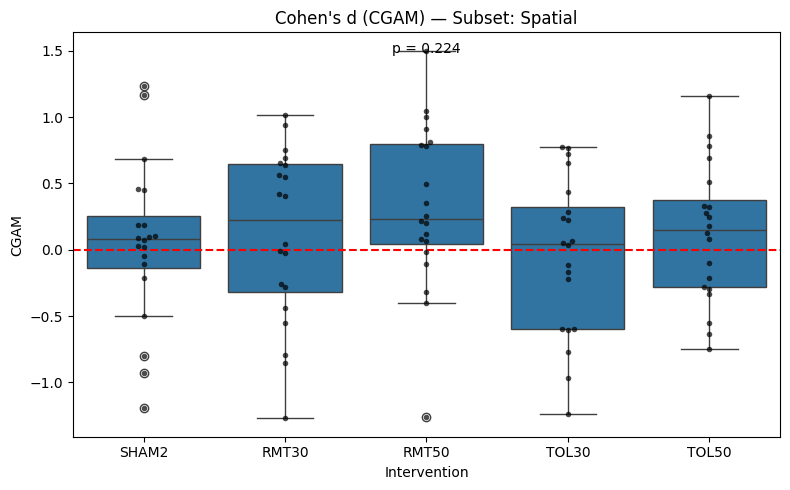

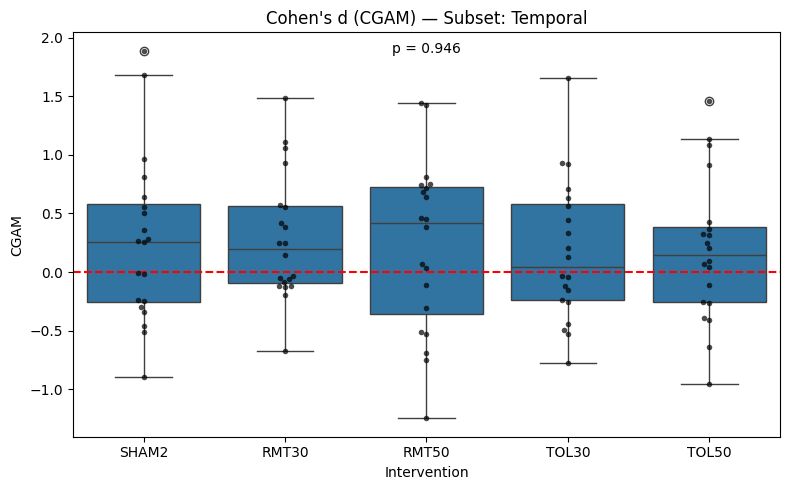

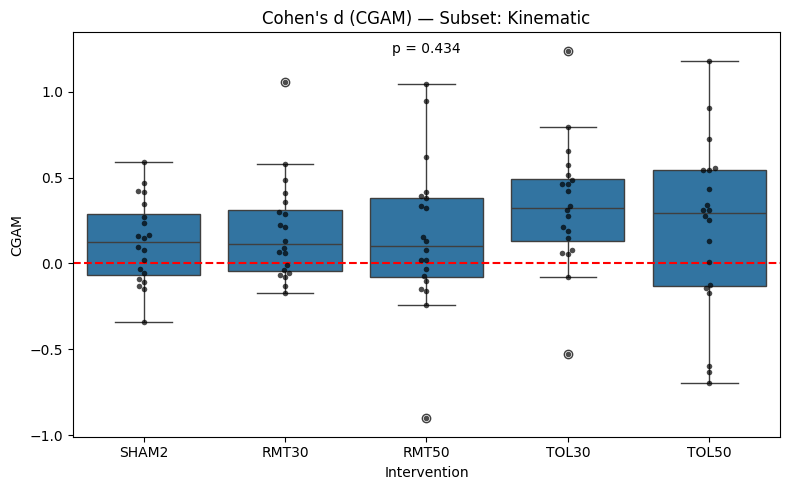

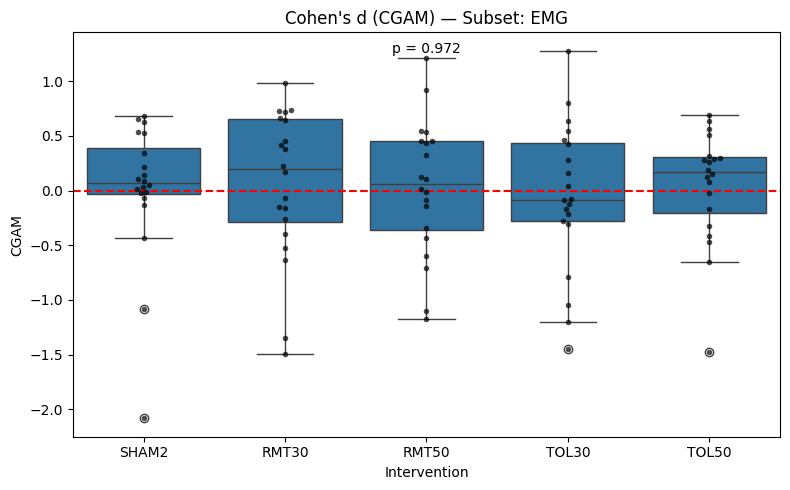

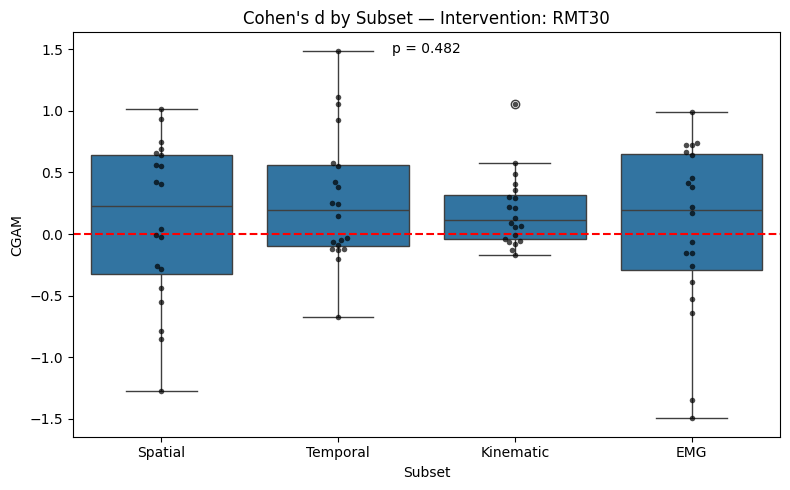

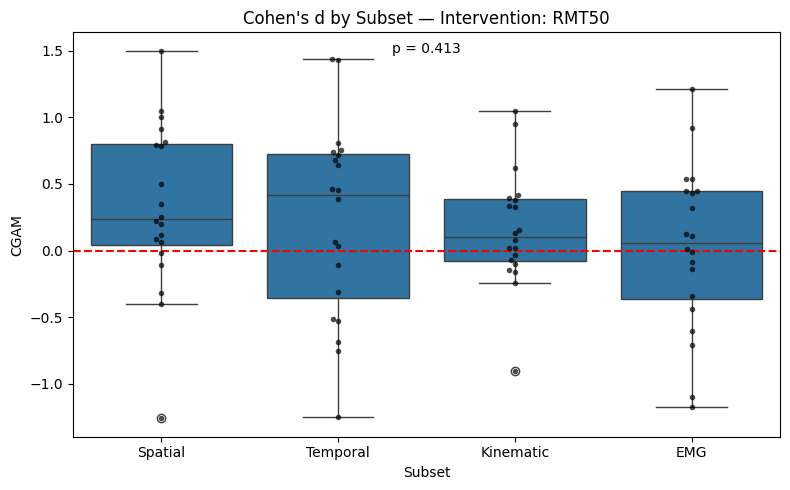

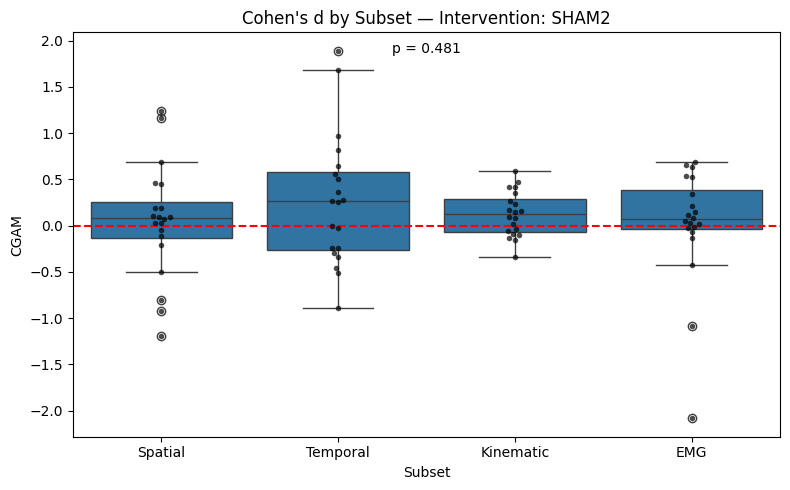

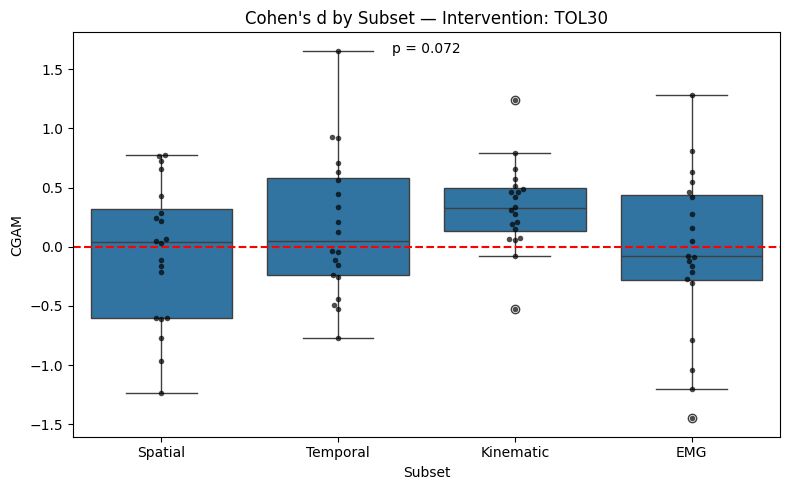

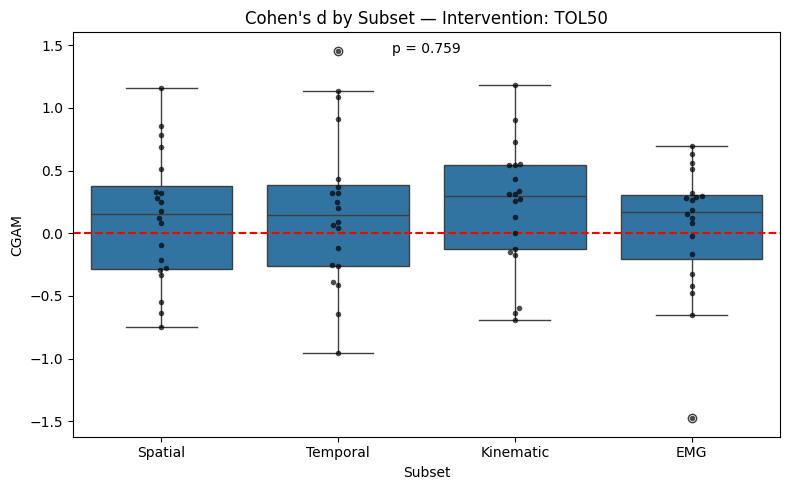


Running stats/figures for speed: SSV

CGAM ranges:
      Subset       min         max
0        EMG  3.754003  181.836538
1  Kinematic  7.073029  149.579560
2    Spatial  0.459388   47.053092
3   Temporal  0.582421   53.940757

Cohen's d ranges:
      Subset       min       max
0        EMG -2.156707  1.612305
1  Kinematic -0.872030  1.060680
2    Spatial -1.642393  2.093757
3   Temporal -1.286458  1.594284

CGAM ranges:
      Subset       min         max
0        EMG  3.754003  181.836538
1  Kinematic  7.073029  149.579560
2    Spatial  0.459388   47.053092
3   Temporal  0.582421   53.940757

Cohen's d ranges:
      Subset       min       max
0        EMG -2.156707  1.612305
1  Kinematic -0.872030  1.060680
2    Spatial -1.642393  2.093757
3   Temporal -1.286458  1.594284

ANOVA (by subset) — Spatial
         Source         SS  DF        MS         F     p-unc       ng2  \
0  Intervention   1.008841   4  0.252210  0.750326  0.560857  0.023622   
1         Error  25.546212  76  0.33613

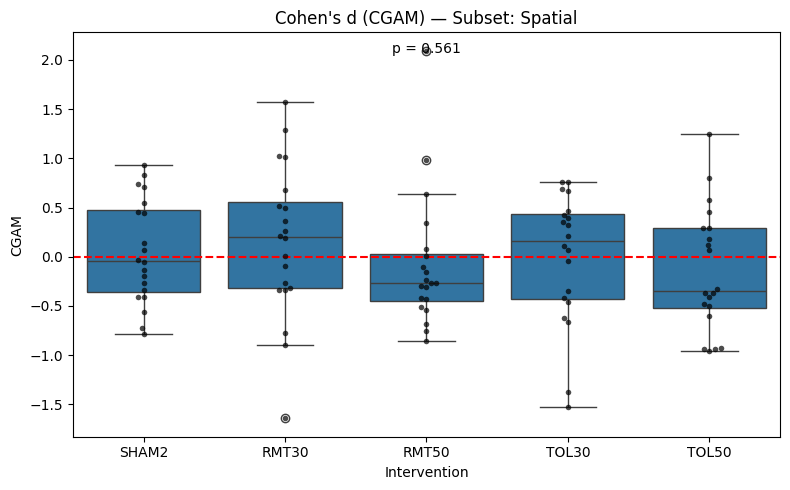

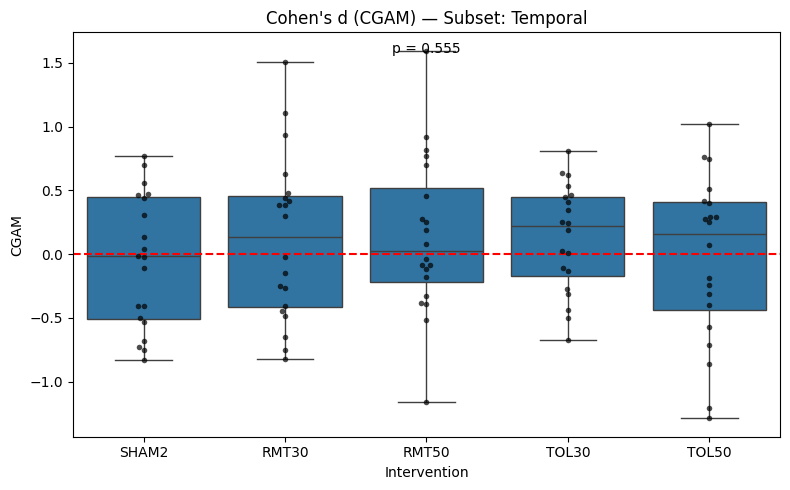

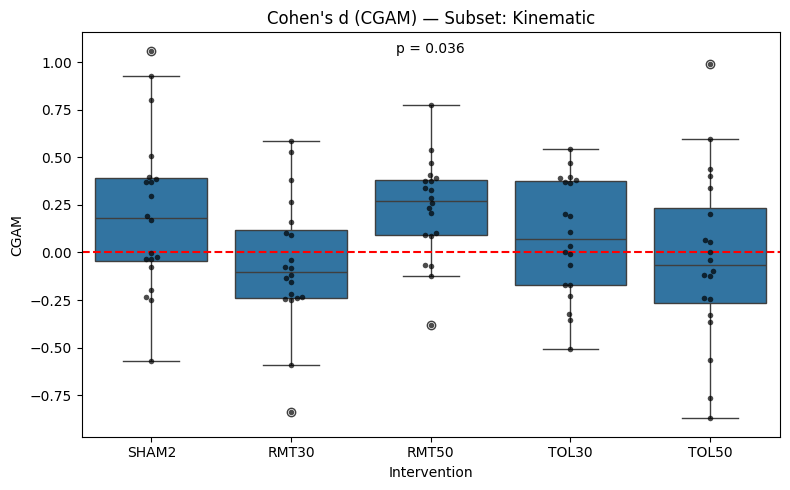

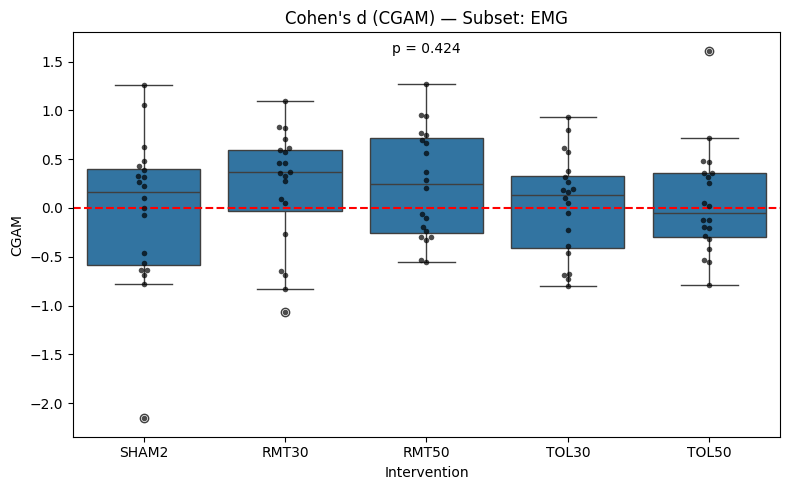

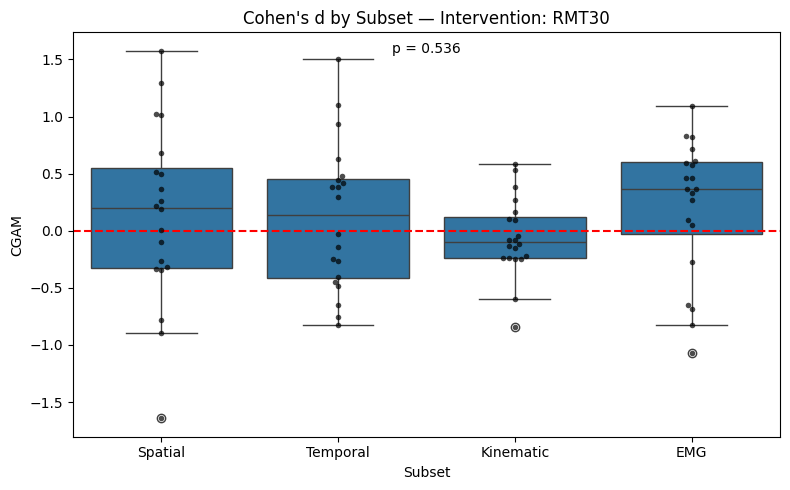

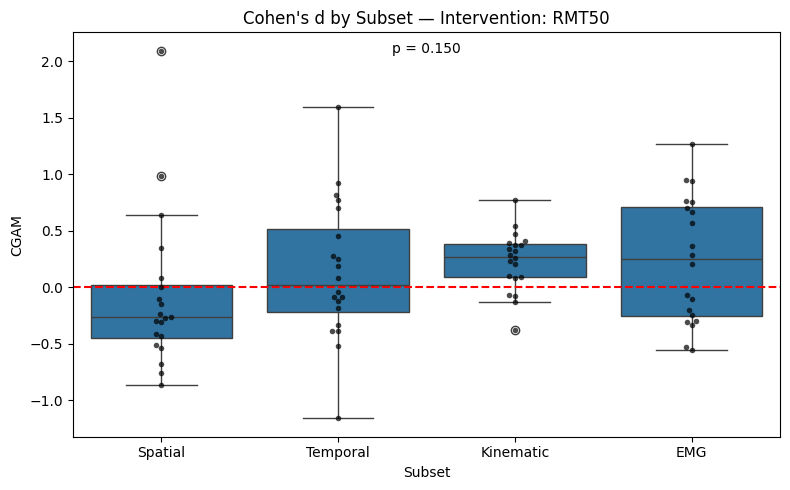

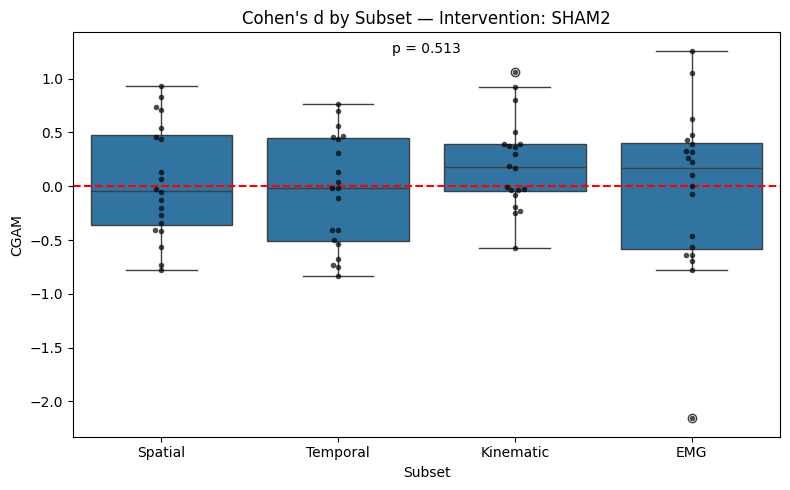

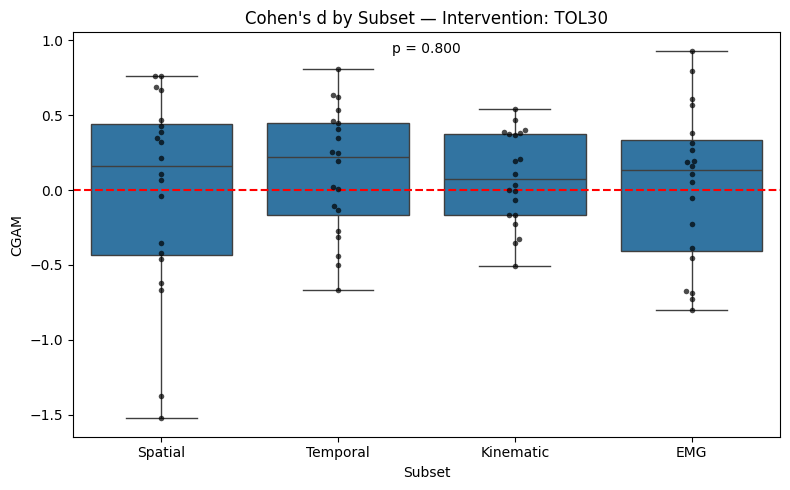

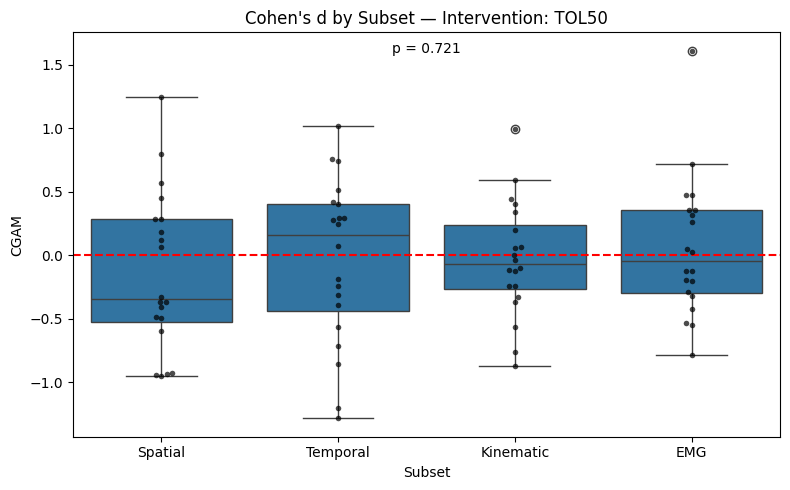

In [60]:
OUTPUT_BASE = r"Y:\LabMembers\J_Hunt\SS_Stroke\CGAM_Exploration\results"

interventions = ['SHAM2', 'RMT30', 'RMT50', 'TOL30', 'TOL50']

for speed in speeds:
    print(f"\nRunning stats/figures for speed: {speed}")
    OUTPUT_DIR = os.path.join(OUTPUT_BASE, speed)
    FIGURES_DIR = os.path.join(OUTPUT_DIR, 'figures')
    STATS_DIR = os.path.join(OUTPUT_DIR, 'stats')
    os.makedirs(FIGURES_DIR, exist_ok=True)
    os.makedirs(STATS_DIR, exist_ok=True)

    PATHS = {
        'cgam_matrix': os.path.join(OUTPUT_DIR, f'matchedCyclesCGAM_{speed}.csv'),
        'cohens': os.path.join(OUTPUT_DIR, f'matchedCyclesCohens_{speed}.csv'),
        'cgam_range': os.path.join(STATS_DIR, f'CGAMrange_{speed}.csv'),
        'cohens_range': os.path.join(STATS_DIR, f'cohensRange_{speed}.csv'),
        'anova_by_subset_dir': STATS_DIR,
        'anova_by_intervention_dir': STATS_DIR
    }

    # Load previously saved results if available
    if os.path.exists(PATHS['cgam_matrix']):
        cgam_matrix_all = pd.read_csv(PATHS['cgam_matrix'])
    else:
        print(f"CGAM file missing for {speed}: {PATHS['cgam_matrix']}")
        cgam_matrix_all = pd.DataFrame()

    if os.path.exists(PATHS['cohens']):
        cohens_df_all = pd.read_csv(PATHS['cohens'])
    else:
        print(f"Cohens file missing for {speed}: {PATHS['cohens']}")
        cohens_df_all = pd.DataFrame()

    if cgam_matrix_all.empty and cohens_df_all.empty:
        print(f"No results for speed {speed}, skipping stats/figures.")
        continue

    # Compute and save ranges when data available
    if not cgam_matrix_all.empty:
        cgam_range = cgam_matrix_all.groupby('Subset')['CGAM'].agg(['min','max']).reset_index()
        cgam_range.to_csv(PATHS['cgam_range'], index=False)
        print("\nCGAM ranges:")
        print(cgam_range)

    if not cohens_df_all.empty:
        cohens_range = cohens_df_all.groupby('Subset')['CGAM'].agg(['min','max']).reset_index()
        cohens_range.to_csv(PATHS['cohens_range'], index=False)
        print("\nCohen's d ranges:")
        print(cohens_range)

    # ANOVAs: by subset and by intervention 
    run_rm_anova_by_subset(cohens_df_all, PATHS['anova_by_subset_dir'])
    run_rm_anova_by_intervention(cohens_df_all, PATHS['anova_by_intervention_dir'])

    # Distribution plots by subset
    plot_cohens_d_distributions(cohens_df_all, interventions, out_dir=FIGURES_DIR)

    # Per-intervention subset plots
    for intervention in cohens_df_all['Intervention'].unique():
        plot_subsets_by_intervention(cohens_df_all, intervention, out_dir=FIGURES_DIR)

# (files were already written in compute step; keep standardized filenames)

def plot_cohens_d_distributions(cohens_df, interventions, out_dir=FIGURES_DIR):
    """Creates boxplots showing Cohen's d across interventions for each feature subset.
    Includes ANOVA p-value to show if differences are significant."""
    for subset in cohens_df['Subset'].unique():
        # Prep data
        df = cohens_df[cohens_df['Subset'] == subset]
        df_melt = df.pivot(index='Subject', columns='Intervention', 
                          values='CGAM').reset_index().melt(
                              id_vars='Subject', value_name='CGAM', 
                              var_name='Intervention')
        
        # Create plot
        fig, ax = plt.subplots(figsize=(8,5))
        sns.boxplot(data=df_melt, x='Intervention', y='CGAM', 
                   order=interventions, ax=ax)
        sns.swarmplot(data=df_melt, x='Intervention', y='CGAM', 
                     color='k', size=4, order=interventions, alpha=0.7, ax=ax)
        
        # Add ANOVA p-value
        anova_file = os.path.join(os.path.dirname(out_dir), 
                                 'stats', f'anova_by_subset_{subset}.csv')
        if os.path.exists(anova_file):
            anova_df = pd.read_csv(anova_file)
            p_val = anova_df.loc[anova_df['Source'] == 'Intervention', 'p-unc'].iloc[0]
            plt.text(0.5, 0.95, f'p = {p_val:.3f}', 
                    horizontalalignment='center', transform=ax.transAxes)
        
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f"Cohen's d (CGAM) — Subset: {subset}")
        plt.tight_layout()
        
        # Save and display
        fpath = os.path.join(out_dir, f'cohens_d_{subset}.png')
        plt.savefig(fpath, bbox_inches='tight')
        plt.show()

def plot_subsets_by_intervention(cohens_df, intervention, subset_order=None, out_dir=FIGURES_DIR):
    """Plot Cohen's d across subsets for a given intervention. Saves file and displays."""
    subset_order = subset_order or ['Spatial','Temporal','Kinematic','EMG']
    df = cohens_df[cohens_df['Intervention'] == intervention].pivot(
        index='Subject', columns='Subset', values='CGAM').dropna()
    if df.empty:
        print(f"No data to plot for intervention: {intervention}")
        return
    df_melt = df.reset_index().melt(id_vars='Subject', value_name='CGAM', var_name='Subset')
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8,5))
    sns.boxplot(data=df_melt, x='Subset', y='CGAM', order=subset_order, ax=ax)
    sns.swarmplot(data=df_melt, x='Subset', y='CGAM', order=subset_order, color='k', size=4, alpha=0.7, ax=ax)
    
    # Get ANOVA p-value from saved file
    anova_file = os.path.join(os.path.dirname(out_dir), 'stats', f'anova_by_intervention_{intervention}.csv')
    if os.path.exists(anova_file):
        anova_df = pd.read_csv(anova_file)
        p_val = anova_df.loc[anova_df['Source'] == 'Subset', 'p-unc'].iloc[0]
        # Add p-value annotation
        plt.text(0.5, 0.95, f'p = {p_val:.3f}', 
                horizontalalignment='center', transform=ax.transAxes)
    
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Cohen's d by Subset — Intervention: {intervention}")
    plt.tight_layout()
    fpath = os.path.join(out_dir, f'cohens_subsets_{intervention}.png')
    plt.savefig(fpath, bbox_inches='tight')
    plt.show()